# Task 2: [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)

What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?

The goal is to replicate the large-scale yfinance OHLCV data download and perform basic financial calculations on IPO stocks.

## 1. Using the same approach as in Question 1, download the IPOs in 2024 from:
https://stockanalysis.com/ipos/2024/
Filter to keep only those IPOs before 1 June 2024 (first 5 months of 2024).
➤ You should have 75 tickers.

In [2]:
import pandas as pd
import numpy as np
import requests
from io import StringIO

def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [4]:

df_pandas = get_ipos_by_year(2024)
df_pandas.columns = df_pandas.columns.str.replace(' ', '')
df_pandas ["IPODate"] = pd.to_datetime(df_pandas ["IPODate"], format="%b %d, %Y", errors="coerce")
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("get_ipos_by_year").getOrCreate()
df = spark.createDataFrame(df_pandas)
spark.sparkContext.setLogLevel("ERROR")

In [5]:
df.show(5)
df.printSchema()

+-------------------+------+--------------------+--------+-------+-------+
|            IPODate|Symbol|         CompanyName|IPOPrice|Current| Return|
+-------------------+------+--------------------+--------+-------+-------+
|2024-12-31 00:00:00|  ONEG|OneConstruction G...|   $4.00|  $5.52| 38.00%|
|2024-12-27 00:00:00|   PHH|Park Ha Biologica...|   $4.00|  $0.66|-83.53%|
|2024-12-23 00:00:00|   HIT|Health In Tech, Inc.|   $4.00|  $2.00|-50.00%|
|2024-12-23 00:00:00|  TDAC|Translational Dev...|  $10.00| $10.33|  3.30%|
|2024-12-20 00:00:00|  RANG|Range Capital Acq...|  $10.00| $10.30|  3.00%|
+-------------------+------+--------------------+--------+-------+-------+
only showing top 5 rows
root
 |-- IPODate: timestamp (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- CompanyName: string (nullable = true)
 |-- IPOPrice: string (nullable = true)
 |-- Current: string (nullable = true)
 |-- Return: string (nullable = true)



In [6]:
from pyspark.sql.functions import to_date, when, col, regexp_extract, regexp_replace

# Clean and convert 'IPO Price' and 'Current' (remove $ and commas, then cast)
df = df.withColumn("IPOPrice", regexp_replace(col("IPOPrice"), "[$,]", "").cast("float"))
df = df.withColumn("Current", regexp_replace(col("Current"), "[$,]", "").cast("float"))

# Clean and convert 'Return' (remove % sign and cast)
df = df.withColumn("Return", regexp_replace(col("Return"), "%", "").cast("float"))
# df = df.withColumn("IPODate", to_date(col("IPODate")))


In [7]:
df.show(5)
df.printSchema()
from pyspark.sql.functions import max,min

df.agg(max("IPODate")).show()
df.agg(min("IPODate")).show()

+-------------------+------+--------------------+--------+-------+------+
|            IPODate|Symbol|         CompanyName|IPOPrice|Current|Return|
+-------------------+------+--------------------+--------+-------+------+
|2024-12-31 00:00:00|  ONEG|OneConstruction G...|     4.0|   5.52|  38.0|
|2024-12-27 00:00:00|   PHH|Park Ha Biologica...|     4.0|   0.66|-83.53|
|2024-12-23 00:00:00|   HIT|Health In Tech, Inc.|     4.0|    2.0| -50.0|
|2024-12-23 00:00:00|  TDAC|Translational Dev...|    10.0|  10.33|   3.3|
|2024-12-20 00:00:00|  RANG|Range Capital Acq...|    10.0|   10.3|   3.0|
+-------------------+------+--------------------+--------+-------+------+
only showing top 5 rows
root
 |-- IPODate: timestamp (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- CompanyName: string (nullable = true)
 |-- IPOPrice: float (nullable = true)
 |-- Current: float (nullable = true)
 |-- Return: float (nullable = true)

+-------------------+
|       max(IPODate)|
+-------------------+
|

In [8]:
from datetime import date
## Filter IPOs in the first 5 months of 2024
df = df.filter(df["IPODate"].between("2024-01-01", "2024-05-31"))

In [9]:
# ticker_list = df.select("Symbol").distinct().rdd.flatMap(lambda x: x).collect()  # Display first 10 distinct symbols
print(df.select("Symbol").distinct().count())
ticker_list = df.select("Symbol").distinct().rdd.flatMap(lambda x: x).collect() 

77


## 2. Use Code Snippet 7 to download daily stock data for those tickers (via yfinance).
- Make sure you understand how growth_1d ... growth_365d, and volatility columns are defined.
- Define a new column growth_252d representing growth after 252 trading days (~1 year), in addition to any other growth periods you already track.

In [10]:
import yfinance as yf
import datetime
import time
from pyspark.sql import Row
from pyspark.sql.functions import col, lag, stddev_samp, sqrt
from pyspark.sql.window import Window

In [ ]:
ALL_TICKERS = ticker_list
stocks_df = pd.DataFrame()

for i, ticker in enumerate(ALL_TICKERS):
    # Get yfinance Ticker object and metadata
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.info
    sector = info.get('sector', 'Unknown')       # Get sector info; default to 'Unknown' if not available
    industry = info.get('industry', 'Unknown')   # Get industry info; default to 'Unknown' if not available

    # Historical daily prices
    historyPrices = ticker_obj.history(period="max", interval="1d")  # Full historical data at daily granularity

    # Add metadata columns for each row of the stock's historical data
    historyPrices['Ticker'] = ticker
    historyPrices['Sector'] = sector
    historyPrices['Industry'] = industry

    # Time-based features
    historyPrices['Year'] = historyPrices.index.year         # Extract year from date
    historyPrices['Month'] = historyPrices.index.month       # Extract month from date
    historyPrices['Weekday'] = historyPrices.index.weekday   # Extract day of the week (0 = Monday)
    historyPrices['Date'] = historyPrices.index.date         # Just the date (not timestamp)

    # Historical return features over various time windows
    for j in [1, 3, 7, 30, 90, 365, 252]:
        historyPrices[f'growth_{j}d'] = historyPrices['Close'] / historyPrices['Close'].shift(j)
        # Computes return = today's close / close j days ago (e.g., 7-day return)

    # Forward-looking return for 30 days ahead (used as prediction target)
    historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']
    # Measures how much price will grow in the next 30 days

    # Technical indicators: moving averages
    historyPrices['SMA10'] = historyPrices['Close'].rolling(10).mean()  # 10-day Simple Moving Average
    historyPrices['SMA20'] = historyPrices['Close'].rolling(20).mean()  # 20-day Simple Moving Average

    # Binary indicator if short-term trend is above long-term trend
    historyPrices['growing_moving_average'] = np.where(
        historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0
    )
    # = 1 if bullish crossover (SMA10 > SMA20), else 0

    # Intraday volatility proxy: normalized daily range
    historyPrices['high_minus_low_relative'] = (
        (historyPrices['High'] - historyPrices['Low']) / historyPrices['Close']
    )
    # Measures price fluctuation within a day, scaled by close price

    # Daily return volatility (rolling standard deviation over 30 days, annualized)Volatility (σ) is a measure of variability, specifically the standard deviation of returns.
    # When you want to convert volatility from one time frame to another (e.g., daily to annual), you don't scale it linearly.
    # Instead, you scale it by the square root of the time period
    #  Return measures how much a stock moves over time
    # Volatility measures how spread out those returns are. 
    historyPrices['volatility'] = historyPrices['growth_1d'].rolling(30).std() * np.sqrt(252)
    ## Volatility is not calculated at daily level.
    # We compute the standard deviation of daily returns over a 30-day window and then annualize it by multiplying by the square root of 252 (the typical number of trading days in a year).
    # Uses daily return (growth_1d) to estimate annualized volatility
    # we don't calculate volatility by rolling 252 days because that would be too long and would smooth out short-term changes. 
    # Volatility is more responsive when calculated over shorter windows like 30 days and supposed to capture recent market conditions.
    # Classification target: whether future return is positive over 30 days
    historyPrices['is_positive_growth_30d_future'] = np.where(
        historyPrices['growth_future_30d'] > 1, 1, 0
    )
    # Binary label: 1 if stock grows over next 30 days, 0 otherwise

    # Sharpe Ratio Calculation (30-day rolling)
    daily_rf = (1 + 0.02) ** (1 / 252) - 1   # Convert 2% annual risk-free rate to daily
    # Assume the risk-free rate is 2% annually (e.g., yield from Treasury bills).
    # Since stock returns are daily, we need a daily equivalent of 2%.
    # Using compounding: daily_rf = (1 + annual_rf)^(1/252) - 1
    historyPrices['excess_return'] = historyPrices['growth_1d'] - daily_rf  # Excess return over RF rate
    #Indcation:  “How much better (or worse) did the stock do than just holding a risk-free bond?”
    # Compensation for risk — how much extra return you're getting above the baseline (risk-free).
    # It removes the “free lunch” from return calculations — focusing only on risky reward.
    # Rolling Sharpe ratio: mean excess return divided by std dev of excess return (annualized)
    # The Sharpe ratio is literally:
    # “Excess return per unit of volatility”
    # excess return = return - risk-free rate = the numerator of the Sharpe ratio
    # volatility = standard deviation of returns = the denominator of the Sharpe ratio
    historyPrices['Sharpe'] = (
        historyPrices['excess_return'].rolling(30).mean() /
        historyPrices['excess_return'].rolling(30).std()
    ) * np.sqrt(252)

    time.sleep(1)  # Pause to avoid hitting API rate limits

    # Append the processed data to the full dataset
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)


In [64]:
stocks_df.Ticker.nunique()

77

In [65]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])


In [66]:
stocks_df['growth_252d'] = stocks_df.groupby('Ticker')['Close'].transform(lambda x: x / x.shift(252))


## 3. Calculate the Sharpe ratio assuming a risk-free rate of 4.5%:

About the 4.5% risk-free rate:
- The risk-free rate typically reflects the return on safe government bonds, like the U.S. 1-year Treasury yield.
- As of recent years, 4.5% is relatively high compared to historical averages (which were often below 2% in the 2010s).
- If your data is recent or expected to reflect a higher interest rate environment, 4.5% can be reasonable.
Otherwise, you might want to adjust the risk-free rate based on current market conditions or use a more precise benchmark (like the current 1-year Treasury yield or overnight rates).
Note: Using a risk-free rate that is too high or low will skew the Sharpe ratio, making assets look worse or better than they really are.

In [67]:
# Sharpe ratio: how much excess return you're getting for the extra volatility (risk) you take on.
stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

In [ ]:
stocks_df.to_pickle('dataframe.pkl')

25/08/03 00:48:26 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 374219 ms exceeds timeout 120000 ms
25/08/03 00:48:26 WARN SparkContext: Killing executors is not supported by current scheduler.
25/08/03 01:05:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

### 4. Filter the DataFrame to keep data only for the trading day:
‘2025-06-06’

In [68]:
stocks_df['Date'].agg(['min', 'max'])

min   2024-01-09
max   2025-08-01
Name: Date, dtype: datetime64[ns]

In [69]:
# Filter the DataFrame for the specific date
filtered_df = stocks_df[stocks_df['Date'] == pd.to_datetime('2025-06-06')]
# print(filtered_df ['Date'].agg(['min', 'max']))
filtered_df.head()

# Compute descriptive statistics for both 'Sharpe' and 'growth_252d'
stats = filtered_df[['Sharpe', 'growth_252d']].describe()

print(stats)


          Sharpe  growth_252d
count  73.000000    73.000000
mean    4.244217     1.215589
std    10.594254     1.485662
min    -0.023865     0.024970
25%     0.245525     0.293333
50%     0.954880     0.758065
75%     3.312559     1.446667
max    77.731762     8.097413


In [ ]:
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


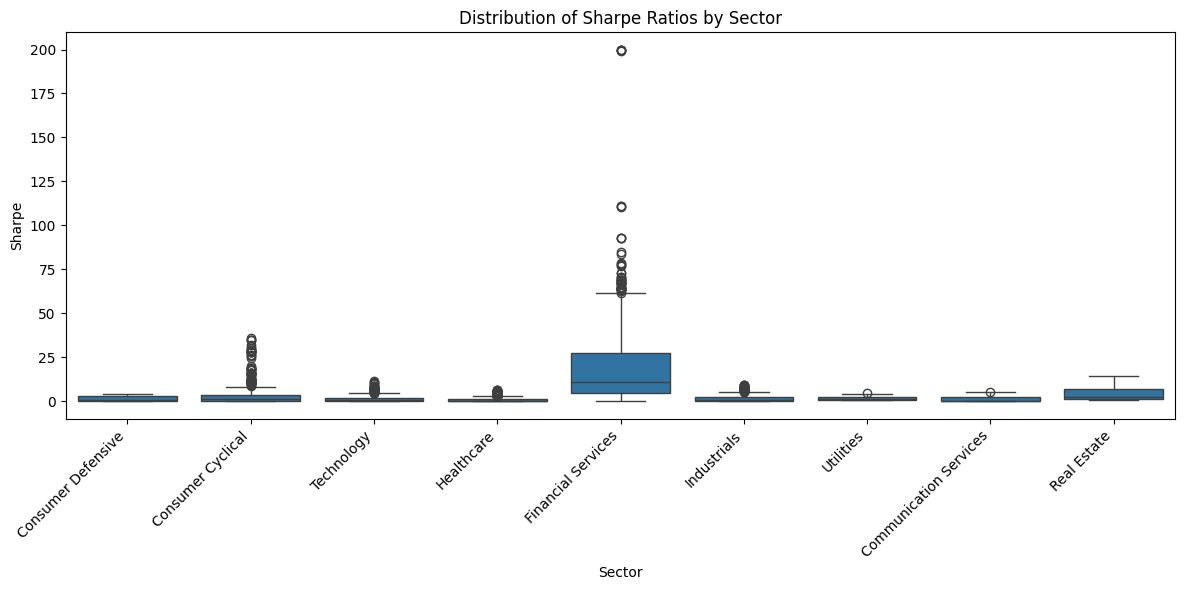

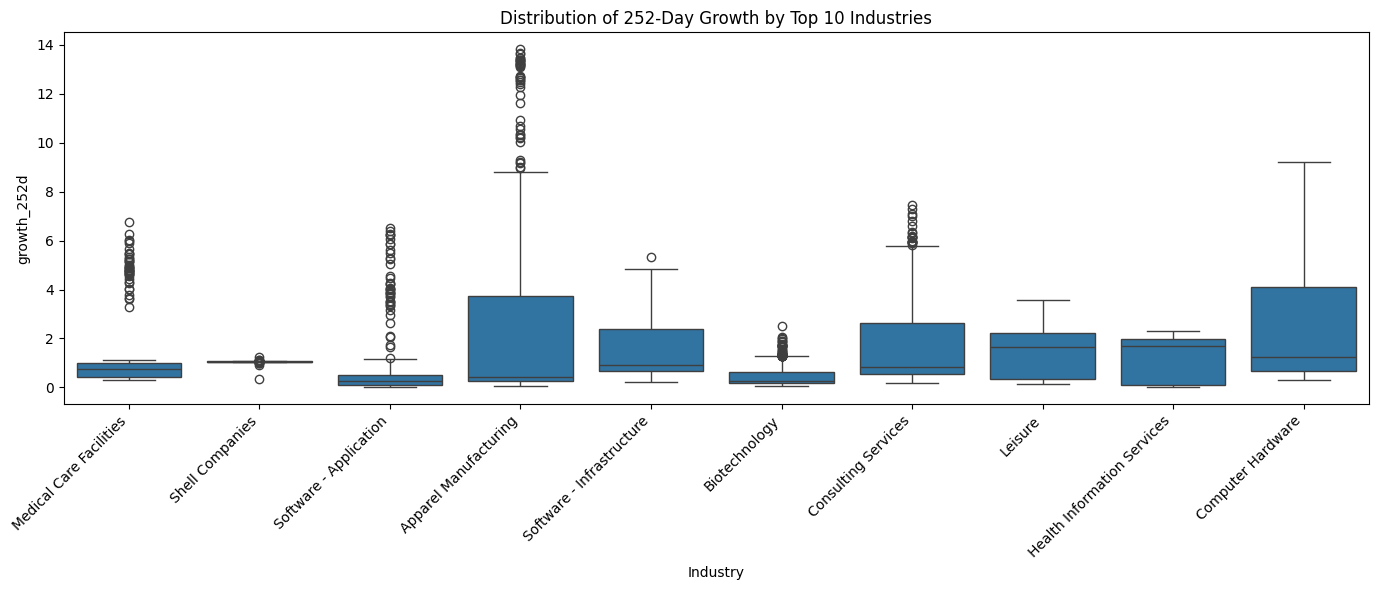

In [70]:
# Drop rows where Sharpe or growth_252d is NaN
plot_df = stocks_df[['Sharpe', 'growth_252d', 'Sector', 'Industry']].dropna()

# --- Boxplot of Sharpe Ratio by Sector ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='Sector', y='Sharpe')
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Sharpe Ratios by Sector")
plt.tight_layout()
plt.show()

# --- Boxplot of 252-day Growth by Industry ---
plt.figure(figsize=(14, 6))
top_industries = plot_df['Industry'].value_counts().nlargest(10).index  # Limit to top 10 industries
sns.boxplot(data=plot_df[plot_df['Industry'].isin(top_industries)],
            x='Industry', y='growth_252d')
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of 252-Day Growth by Top 10 Industries")
plt.tight_layout()
plt.show()


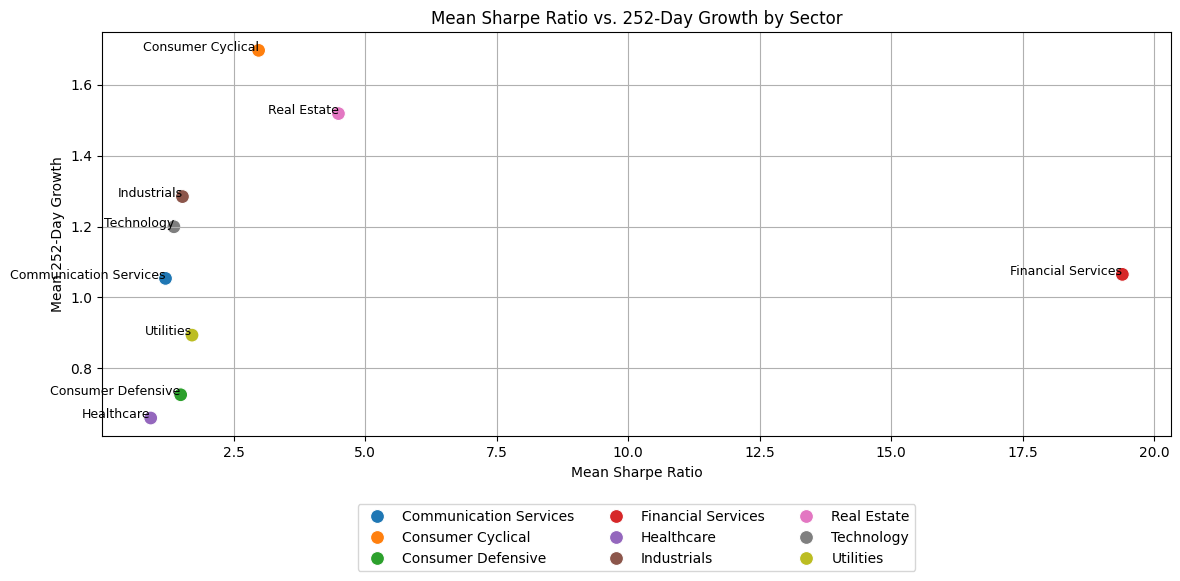

In [79]:
# Prepare data: group by Sector and compute mean Sharpe and growth_252d
sector_agg = plot_df.groupby('Sector')[['Sharpe', 'growth_252d']].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=sector_agg, x='Sharpe', y='growth_252d', hue='Sector', s=100)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

for _, row in sector_agg.iterrows():
    plt.text(row['Sharpe'], row['growth_252d'], row['Sector'], fontsize=9, ha='right')

plt.title("Mean Sharpe Ratio vs. 252-Day Growth by Sector")
plt.xlabel("Mean Sharpe Ratio")
plt.ylabel("Mean 252-Day Growth")
plt.grid(True)
plt.tight_layout()
plt.show()


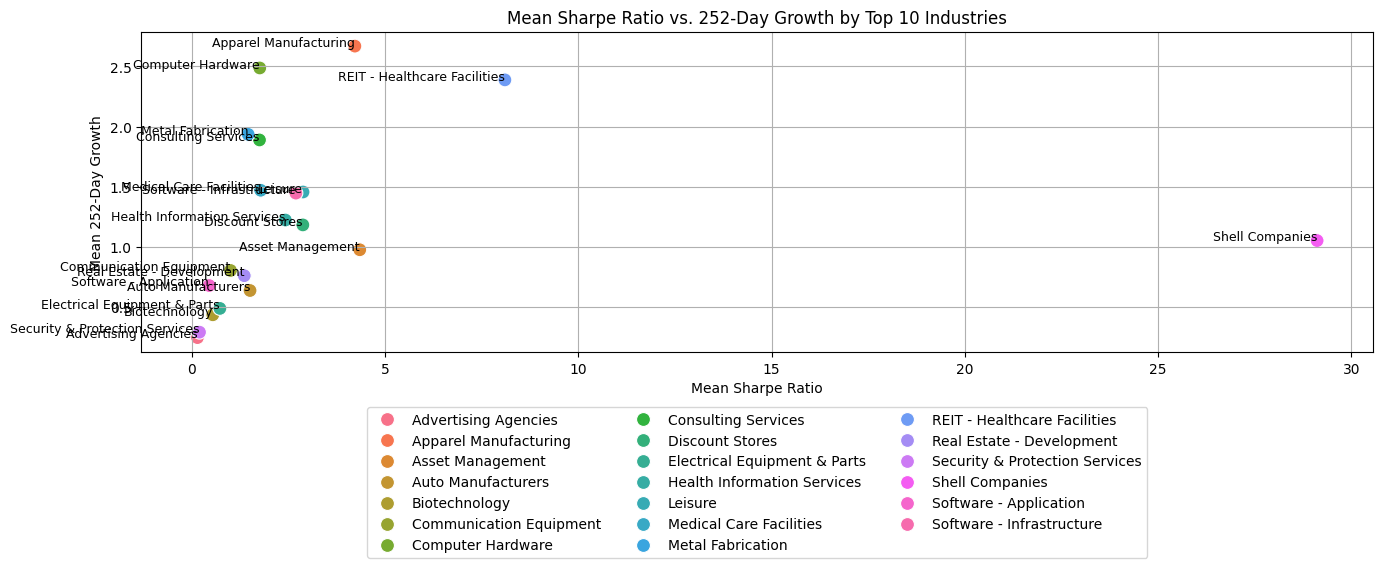

In [78]:
# Filter top 10 industries by count
top_industries = plot_df['Industry'].value_counts().nlargest(20).index
industry_agg = plot_df[plot_df['Industry'].isin(top_industries)].groupby('Industry')[['Sharpe', 'growth_252d']].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.scatterplot(data=industry_agg, x='Sharpe', y='growth_252d', hue='Industry', s=100)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


for _, row in industry_agg.iterrows():
    plt.text(row['Sharpe'], row['growth_252d'], row['Industry'], fontsize=9, ha='right')

plt.title("Mean Sharpe Ratio vs. 252-Day Growth by Top 10 Industries")
plt.xlabel("Mean Sharpe Ratio")
plt.ylabel("Mean 252-Day Growth")
plt.grid(True)
plt.tight_layout()
plt.show()


### Industry Profiles Based on Sharpe Ratio and 252-Day Growth
#### High Sharpe Ratio & Average Growth
- Consistent, stable returns with low volatility
- Indicates a low-risk, moderate-return industry
- Attractive for risk-averse investors seeking steady performance
Examples: Utilities, Consumer Staples, Healthcare
#### Low Sharpe Ratio & High Growth
- High returns but very volatile and risky
- Reflects a high-risk, high-reward industry
- Suitable for investors with high risk tolerance chasing big gains
Examples: Tech startups, Biotech, Commodities
#### Low Sharpe Ratio & Low Growth
- Poor returns coupled with high volatility
- Signals high risk with little reward — a potentially struggling or unstable industry
- Generally unattractive for most investors without special circumstances
- Could indicate industries in decline or facing structural challenges

### 5. Answer:

- What is the median Sharpe ratio for these 71 stocks?
- Note: Positive Sharpe means growth exceeding the risk-free rate of 4.5%.
- [Additional] Do you observe the same top 10 companies when sorting by growth_252d versus sorting by Sharpe?

Answer:
Mean sharpe ratio is 0.95

In [81]:
df = stocks_df[['Ticker','Sharpe', 'growth_252d', 'Sector', 'Industry']].dropna()
# First, group by ticker and calculate the mean of Sharpe and growth_252d
agg_df = df.groupby(['Ticker', 'Sector', 'Industry'])[['Sharpe', 'growth_252d']].mean().reset_index()
# Top 10 tickers by Sharpe ratio
top10_sharpe = agg_df.sort_values(by='Sharpe', ascending=False).head(10)
print("Top 10 tickers by Sharpe ratio:")
print(top10_sharpe[['Ticker', 'Sector', 'Industry','Sharpe']])

# Top 10 tickers by 252-day growth
top10_growth = agg_df.sort_values(by='growth_252d', ascending=False).head(10)
print("\nTop 10 tickers by 252-day growth:")
print(top10_growth[['Ticker', 'Sector', 'Industry','growth_252d']])

Top 10 tickers by Sharpe ratio:
   Ticker              Sector               Industry     Sharpe
54   RFAI  Financial Services        Shell Companies  64.490521
20   GPAT  Financial Services        Shell Companies  55.246254
30   JVSA  Financial Services        Shell Companies  52.169201
25   IBAC  Financial Services        Shell Companies  34.246266
6    BKHA  Financial Services        Shell Companies  34.214555
33   LEGT  Financial Services        Shell Companies  26.177311
18   DYCQ  Financial Services        Shell Companies  21.713119
11   CCIX  Financial Services        Shell Companies  16.345522
29     JL   Consumer Cyclical  Apparel Manufacturing   9.904139
24   HLXB  Financial Services        Shell Companies   9.351965

Top 10 tickers by 252-day growth:
   Ticker             Sector                        Industry  growth_252d
29     JL  Consumer Cyclical           Apparel Manufacturing     6.020516
44   NAKA         Healthcare         Medical Care Facilities     4.903030
69   UM